# HELIOS Seq Analysis of Hek cells
## What has been done so far...
Several DataProcessing steps were done till here with other software on the computational cluster
* fastq were trimmed and demultiplexed with cutadapt
* quality checked and further trimmed with trimmomatic
* reads were aligned with hisat2 to reference genome and reference spikeRNA, done for merged reads and not merged/paired reads separately
* count tables produced with featureCounts
* a custom python script extracts output from hisat2 for the spike RNAs and puts them in a table for further processing
* in 01_Analysis data was
  * annotated
  * filtered
  * normalized
  * spike content was compared
* in 02_Analysis calculation were made:
  * enrichmentfactors
  * logfoldchanges
  * statistical tests



In [1]:
# import required modules
import os
import pandas as pd
import numpy as np
import anndata as ad
import gseapy as gp
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
from scipy.stats import ranksums
from scipy.stats import ttest_ind
from confidence_ellypse import confidence_ellipse
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles

colors = sns.color_palette("tab10")
colors[8] = "gold"

from sklearn.preprocessing import StandardScaler

#pd.set_option('display.max_columns', None)

In [2]:
adata = ad.read_h5ad("data/anndata.h5ad")
adata

AnnData object with n_obs × n_vars = 24 × 5588
    obs: 'encoding', 'pos_neg', 'treatment', 'gene_counts', 'biotinRna', 'biotin_scalingF'
    var: 'Chr', 'Start', 'End', 'Strand', 'Length', 'Ensemble_ID', 'ensembl_gene_id', 'external_gene_name', 'description', 'gene_biotype', 'entrezgene_id', 'start_position', 'end_position', 'chromosome_name', 'total_values', 'highest_sample', 'NADcap_Control', 'NADcap_FK', 'NADcap_NRH', 'NADcap_Rot'
    uns: 'L2FC_spikes', 'enrichmentfactors_spikes', 'normalized_spike_counts', 'original_spike_table', 'spike_correlation', 'spike_counts'
    varm: 'L2FC', 'L2FC_mean_statTests', 'enrichmentfactors'
    layers: 'biotin_scaled'

In [3]:
# import significant genes from NAD captured Seq (previous) and put them in a dictionary
sig_genes_previous_analysis = {}
for file in os.walk("data/tay_datasets"):
    data_sets = file[2]
for dataset in data_sets:
    df = pd.read_csv("data/tay_datasets/" + dataset)["ensembl_gene_id_version"]
    sig_genes_previous_analysis[dataset] = set(df)
sig_genes_previous_analysis.keys()

dict_keys(['vol_data_nrh_sig.csv', 'vol_data_old_sig.csv', 'vol_data_fk_sig.csv', 'vol_data_con_sig.csv', 'vol_data_rot_sig.csv'])

In [4]:
treatments = ["Control", "NRH", "FK", "Rot"]
sig_genes_new_analysis = {}
for treat in treatments:
    sig_genes_new_analysis[treat] = set(adata.var[adata.var["NADcap_" + treat] == True].index)


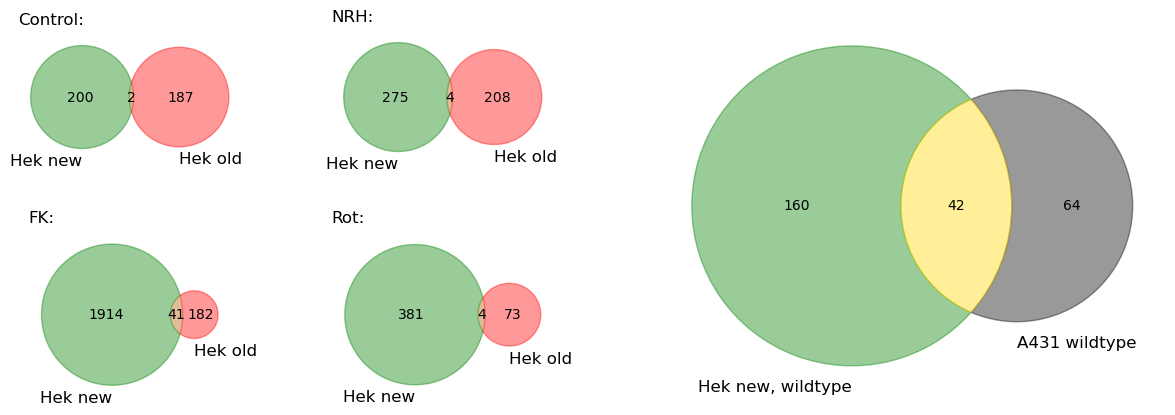

In [18]:
# create map to find partners
pairs = {
    "NRH" : "vol_data_nrh_sig.csv",
    "Control" : "vol_data_con_sig.csv",
    "FK" : "vol_data_fk_sig.csv",
    "Rot" : "vol_data_rot_sig.csv",
}
# greate a figure grid to place stuff into
plt.rcParams.update({'figure.figsize':(15,5), 'figure.dpi':100})
grid = plt.GridSpec(2, 4, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0, 0])
ax2 = plt.subplot(grid[0, 1])
ax3 = plt.subplot(grid[1, 0])
ax4 = plt.subplot(grid[1, 1])
ax5 = plt.subplot(grid[0:2,2:])

# make the big vennchart overlap with A431 on the right
set_scincancer = set(pd.read_csv("data/sig_genes_A431.csv")["Feature"])
v = venn2([sig_genes_new_analysis["Control"], set_scincancer], ("Hek new, wildtype", "A431 wildtype"), ax = ax5)
v.get_patch_by_id('01').set_color('black')
v.get_patch_by_id('11').set_color('gold')
v.get_patch_by_id('10').set_color('green')


# create the 4 smaller venn charts on the left in a loop by iterating over the pairs
# simultaniously create a big union intersection for later analysis

union_intersect = set([])

NADcapped_genes ={}

axs = [ax1, ax2, ax3, ax4]

for ax, treat in zip(axs, treatments):  

    
    set1 = sig_genes_new_analysis[treat]
    name_set2 = pairs[treat]
    set2 = sig_genes_previous_analysis[name_set2]
    
    v = venn2([set1, set2], ('Hek new', 'Hek old'), ax = ax)
    v.get_patch_by_id('10').set_color('green')
    v.get_patch_by_id('01').set_color('red')
    
       
    
    union_intersect = union_intersect.union(set1.intersection(set2))
    
    ax.set_title(treat +":", loc = "left", fontsize = 12)


plt.savefig("figures/overlap_previous_data.png", dpi=300, pad_inches=0)
plt.show()


In [21]:
# what are the genes found in the big union of all intersecting genes?
# these ones are found in old and new data 
adata[:, list(union_intersect)].var

,Chr,Start,End,Strand,Length,Ensemble_ID,ensembl_gene_id,external_gene_name,description,gene_biotype,entrezgene_id,start_position,end_position,chromosome_name,total_values,highest_sample,NADcap_Control,NADcap_FK,NADcap_NRH,NADcap_Rot
Feature,,,,,,,,,,,,,,,,,,,,
ENSG00000100418.8,chr22;chr22;chr22;chr22;chr22;chr22;chr22;chr2...,41598028;41600893;41602001;41602424;41602975;4...,41601190;41601190;41602783;41602523;41603381;4...,-;-;-;-;-;-;-;-;-;-;-;-;-,4919,ENSG00000100418,ENSG00000100418,DESI1,desumoylating isopeptidase 1 [Source:HGNC Symb...,protein_coding,27351.0,41598028,41621043,22,65,22,False,True,False,False
ENSG00000262049.2,chr17,81701324,81703317,-,1994,ENSG00000262049,ENSG00000262049,NaN,"novel transcript, antisense to HGS",lncRNA,NaN,81701324,81703317,17,11,6,False,True,False,False
ENSG00000272888.8,chr15;chr15;chr15;chr15;chr15;chr15;chr15;chr1...,92819540;92819598;92882707;92882732;92882862;9...,92819998;92819992;92883186;92883186;92883186;9...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,6465,ENSG00000272888,ENSG00000272888,CHASERR,CHD2 adjacent suppressive regulatory RNA [Sour...,lncRNA,NaN,92819540,92899701,15,159,51,False,True,False,False
ENSG00000155959.12,chrX;chrX;chrX;chrX;chrX;chrX;chrX;chrX;chrX;c...,155197007;155208874;155208904;155216460;155220...,155197139;155208981;155208981;155216575;155220...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+,1948,ENSG00000155959,ENSG00000155959,VBP1,VHL binding protein 1 [Source:HGNC Symbol;Acc:...,protein_coding,7411.0,155197007,155239841,X,91,43,False,True,False,False
ENSG00000115866.11,chr2;chr2;chr2;chr2;chr2;chr2;chr2;chr2;chr2;c...,135905881;135906824;135907244;135907260;135910...,135907407;135907407;135907407;135907407;135911...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,4752,ENSG00000115866,ENSG00000115866,DARS1,aspartyl-tRNA synthetase 1 [Source:HGNC Symbol...,protein_coding,1615.0,135905881,135986100,2,48,19,False,True,False,False
ENSG00000013503.10,chr12;chr12;chr12;chr12;chr12;chr12;chr12;chr1...,106357748;106358082;106363870;106363870;106366...,106357951;106358222;106363902;106363902;106366...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,4768,ENSG00000013503,ENSG00000013503,POLR3B,RNA polymerase III subunit B [Source:HGNC Symb...,protein_coding,55703.0,106357748,106510198,12,48,43,False,True,False,False
ENSG00000110315.7,chr11;chr11;chr11;chr11;chr11;chr11;chr11;chr1...,10511673;10511923;10518318;10519034;10519034;1...,10515066;10517740;10519141;10519141;10519141;1...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-,7825,ENSG00000110315,ENSG00000110315,RNF141,ring finger protein 141 [Source:HGNC Symbol;Ac...,protein_coding,50862.0,10511673,10541230,11,67,60,False,True,False,False
ENSG00000184840.12,chr5;chr5;chr5;chr5;chr5;chr5;chr5;chr5;chr5;c...,177592203;177592217;177592272;177592488;177592...,177592398;177592675;177592398;177592675;177592...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+,3513,ENSG00000184840,ENSG00000184840,TMED9,transmembrane p24 trafficking protein 9 [Sourc...,protein_coding,54732.0,177592203,177597242,5,100,45,False,True,False,False
ENSG00000202400.1,chr2,231460371,231460440,-,70,ENSG00000202400,ENSG00000202400,SNORD82,"small nucleolar RNA, C/D box 82 [Source:HGNC S...",snoRNA,25826.0,231460371,231460440,2,199,60,True,False,True,True


In [16]:
# Which features are intersecting across cells?
intersect_adata = adata[:, adata.var.index.isin(list(set_scincancer.intersection(sig_genes_new_analysis["Control"])))]
intersect_adata.var[["Length", "external_gene_name", "description", "gene_biotype",
                    "NADcap_Control", "NADcap_NRH", "NADcap_FK", "NADcap_Rot"]]

,Length,external_gene_name,description,gene_biotype,NADcap_Control,NADcap_NRH,NADcap_FK,NADcap_Rot
Feature,,,,,,,,
ENSG00000260464.1,1766,NaN,novel transcript,lncRNA,True,True,True,True
ENSG00000283696.1,997,NaN,novel transcript,lncRNA,True,False,True,True
ENSG00000143226.16,5422,FCGR2A,Fc gamma receptor IIa [Source:HGNC Symbol;Acc:...,protein_coding,True,False,False,False
ENSG00000230530.2,4528,LIMD1-AS1,LIMD1 antisense RNA 1 [Source:HGNC Symbol;Acc:...,lncRNA,True,True,True,True
ENSG00000177733.7,8713,HNRNPA0,heterogeneous nuclear ribonucleoprotein A0 [So...,protein_coding,True,False,True,True
ENSG00000248473.2,4759,LINC01962,long intergenic non-protein coding RNA 1962 [S...,lncRNA,True,True,True,True
ENSG00000196787.4,493,H2AC11,H2A clustered histone 11 [Source:HGNC Symbol;A...,protein_coding,True,True,True,False
ENSG00000075618.18,3699,FSCN1,fascin actin-bundling protein 1 [Source:HGNC S...,protein_coding,True,True,True,True
ENSG00000172115.9,5791,CYCS,"cytochrome c, somatic [Source:HGNC Symbol;Acc:...",protein_coding,True,True,True,True


In [10]:
# saving relevant Information to an excel file

# Create a Pandas Excel writer using XlsxWriter as the engine.

# export spike related data
with pd.ExcelWriter("data/Hek_spikerelated_data.xlsx") as writer:

    # Write each dataframe to a different worksheet.
    adata.uns["spike_counts"].to_excel(writer, sheet_name="spike_counts")
    adata.uns["normalized_spike_counts"].to_excel(writer, sheet_name="spike_counts_norm")
    adata.uns["L2FC_spikes"].to_excel(writer, sheet_name="L2FC_spikes")
    adata.uns["enrichmentfactors_spikes"].to_excel(writer, sheet_name="enrichmentfactors_spikes")
    adata.uns["spike_correlation"].to_excel(writer, sheet_name="spike_correlation")

# export filtered count related data
with pd.ExcelWriter("data/Hek_countrelated_data.xlsx") as writer:
    
    pd.DataFrame(np.array(adata.X.T), 
                 columns = adata.obs_names, 
                 index = adata.var_names).to_excel(writer, sheet_name="raw_counts")

    pd.DataFrame(np.array(adata.layers["biotin_scaled"].T.round(2)), 
                 columns = adata.obs_names, 
                 index = adata.var_names).to_excel(writer, sheet_name="norm_counts")
    
    
# export the gene related data
with pd.ExcelWriter("data/Hek_featurerelated_data.xlsx") as writer:
    adata.var.to_excel(writer, sheet_name="gene_info")
    adata.varm["enrichmentfactors"].to_excel(writer, sheet_name="enrichmentfactors")
    adata.varm["L2FC"].to_excel(writer, sheet_name="l2fc")
    adata.varm["L2FC_mean_statTests"].to_excel(writer, sheet_name="L2FC_mean_statTests")
    